In [3]:
import os
import torch
from torch import nn, optim
import torchvision
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [4]:
# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True
plt.rcParams["grid.linestyle"] = ":"

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

# GPU 디바이스 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Vanilla RNN

In [4]:
torch.manual_seed(327)

input_size = 2
hidden_size = 6

inputs = torch.rand((1, 5, input_size))
print(inputs)

tensor([[[0.6774, 0.7673],
         [0.4179, 0.6561],
         [0.6547, 0.0184],
         [0.8064, 0.4642],
         [0.9863, 0.8188]]])


In [5]:
rnn = nn.RNN(input_size, hidden_size, batch_first=True)

print(list(rnn.parameters()))

[Parameter containing:
tensor([[-0.3949, -0.3016],
        [-0.0679,  0.2841],
        [ 0.1791,  0.1719],
        [ 0.1117, -0.3117],
        [-0.2380,  0.1490],
        [ 0.0539, -0.2061]], requires_grad=True), Parameter containing:
tensor([[-0.0406, -0.3738,  0.2566, -0.2126,  0.0542, -0.1427],
        [ 0.2324,  0.0509, -0.3607, -0.1245,  0.0319, -0.3869],
        [-0.1693,  0.1986,  0.1106, -0.1166,  0.3346, -0.1749],
        [ 0.3323, -0.0458,  0.2114,  0.1915,  0.2052,  0.2288],
        [-0.2279, -0.1918,  0.1954, -0.0518, -0.1844,  0.1782],
        [ 0.3094, -0.3480, -0.0481,  0.1050,  0.3970, -0.3059]],
       requires_grad=True), Parameter containing:
tensor([-0.0447, -0.2085,  0.3493,  0.3195,  0.2847,  0.1503],
       requires_grad=True), Parameter containing:
tensor([ 0.0708,  0.3253,  0.0195, -0.2816, -0.3298,  0.2592],
       requires_grad=True)]


In [7]:
outputs, _status = rnn(inputs)

print(outputs)
print(_status)

tensor([[[-0.4405,  0.2810,  0.5526, -0.1249, -0.0917,  0.2802],
         [-0.2919, -0.1079,  0.5933, -0.1400,  0.1790, -0.0988],
         [ 0.0200, -0.1473,  0.5891,  0.1254, -0.0384,  0.4188],
         [-0.3054, -0.1976,  0.4814,  0.2291,  0.0461,  0.2507],
         [-0.4483, -0.0960,  0.6023,  0.0130,  0.0679,  0.2077]]],
       grad_fn=<TransposeBackward1>)
tensor([[[-0.4483, -0.0960,  0.6023,  0.0130,  0.0679,  0.2077]]],
       grad_fn=<StackBackward0>)


In [8]:
input_str = 'apple'
output_str = 'pple!'

In [19]:
## Vocab set

char_vocab = sorted(list(set(input_str+output_str)))
vocab_size = len(char_vocab)

print(char_vocab)
print(vocab_size)

['!', 'a', 'e', 'l', 'p']
5


In [21]:
## indexing

char_to_index = dict((c, i) for i, c in enumerate(char_vocab))
print(char_to_index)
index_to_char = dict((i, c) for i, c in enumerate(char_vocab))
print(index_to_char)

{'!': 0, 'a': 1, 'e': 2, 'l': 3, 'p': 4}
{0: '!', 1: 'a', 2: 'e', 3: 'l', 4: 'p'}


In [25]:
## Label encoding

x_data = [[char_to_index[c] for c in input_str]]
y_data = [[char_to_index[c] for c in output_str]]

print(x_data)
print(y_data)

[[1, 4, 4, 3, 2]]
[[4, 4, 3, 2, 0]]


In [34]:
## One-hot encoding

x_one_hot = np.identity(vocab_size)[x_data]
print(x_one_hot)

[[[0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 1. 0.]
  [0. 0. 1. 0. 0.]]]


In [43]:
## to Tensor

X = torch.tensor(x_one_hot).float()
Y = torch.tensor(y_data)

X = X.to(device)
Y = Y.to(device)

print(X)
print(Y)
print(X.dtype)
print(Y.dtype)

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0.]]])
tensor([[4, 4, 3, 2, 0]])
torch.float32
torch.int64


In [53]:
## Model

input_size = vocab_size
hidden_size = 6
output_size = 5
lr = 0.1

In [54]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size, bias=True)

  def forward(self, x):
    x, _status = self.rnn(x)
    x = self.fc(x)
    return x

In [55]:
net = VanillaRNN(input_size, hidden_size, output_size).to(device)
list(net.parameters())

[Parameter containing:
 tensor([[-0.2840,  0.2556,  0.2121,  0.2166,  0.2835],
         [-0.3818, -0.3196,  0.2037, -0.2653, -0.1914],
         [-0.0403, -0.3608, -0.0865, -0.2605,  0.2316],
         [ 0.2581,  0.3624, -0.4020, -0.0176,  0.3099],
         [-0.3485,  0.2708,  0.3922,  0.3128,  0.2389],
         [ 0.1905,  0.3510, -0.2708,  0.1824,  0.3416]], requires_grad=True),
 Parameter containing:
 tensor([[-0.2757, -0.1407,  0.3686,  0.4068, -0.2456, -0.3331],
         [ 0.1273,  0.2319, -0.3194,  0.1481, -0.0636, -0.1398],
         [-0.3663,  0.0347, -0.2362,  0.1335,  0.4041,  0.2552],
         [ 0.2765,  0.2409,  0.3865, -0.0782, -0.0632,  0.3854],
         [-0.0689,  0.2694, -0.1513,  0.3413,  0.2929,  0.3395],
         [ 0.3428, -0.0105, -0.0257,  0.2872, -0.3295,  0.1832]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.3724, -0.1921,  0.0048, -0.4046,  0.3371,  0.0423],
        requires_grad=True),
 Parameter containing:
 tensor([-0.1277, -0.0943, -0.2751, -

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

In [57]:
num_epochs = 100

for epoch in range(num_epochs):
  outputs = net(X)
  loss = criterion(outputs.squeeze(0), Y.squeeze(0))
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  result = outputs.argmax(-1)
  result_str = f"{''.join([index_to_char[c] for c in result.squeeze().numpy()])}"
  print(f"epoch = {epoch}, loss = {loss.item():.3f}, prediction = {result}, y_data = {y_data}, pred_str = {result_str}")

epoch = 0, loss = 1.658, prediction = tensor([[2, 2, 3, 1, 1]]), y_data = [[4, 4, 3, 2, 0]], pred_str = eelaa
epoch = 1, loss = 1.318, prediction = tensor([[4, 4, 2, 2, 0]]), y_data = [[4, 4, 3, 2, 0]], pred_str = ppee!
epoch = 2, loss = 1.074, prediction = tensor([[4, 4, 3, 4, 0]]), y_data = [[4, 4, 3, 2, 0]], pred_str = pplp!
epoch = 3, loss = 0.826, prediction = tensor([[4, 4, 3, 2, 0]]), y_data = [[4, 4, 3, 2, 0]], pred_str = pple!
epoch = 4, loss = 0.575, prediction = tensor([[4, 4, 3, 2, 0]]), y_data = [[4, 4, 3, 2, 0]], pred_str = pple!
epoch = 5, loss = 0.368, prediction = tensor([[4, 4, 3, 2, 0]]), y_data = [[4, 4, 3, 2, 0]], pred_str = pple!
epoch = 6, loss = 0.228, prediction = tensor([[4, 4, 3, 2, 0]]), y_data = [[4, 4, 3, 2, 0]], pred_str = pple!
epoch = 7, loss = 0.143, prediction = tensor([[4, 4, 3, 2, 0]]), y_data = [[4, 4, 3, 2, 0]], pred_str = pple!
epoch = 8, loss = 0.091, prediction = tensor([[4, 4, 3, 2, 0]]), y_data = [[4, 4, 3, 2, 0]], pred_str = pple!
epoch = 9,

## koeran RNN

In [110]:
text = "안녕하세요 여러분"
input_str_kr = text
label_str_kr = text[1:] + "!"

print(input_str_kr)
print(label_str_kr)

안녕하세요 여러분
녕하세요 여러분!


In [111]:
## Vocab set

voc_set = set(input_str_kr + label_str_kr)
char_vocab = sorted(list(voc_set))
vocab_size = len(char_vocab)

print(voc_set)
print(char_vocab)
print(vocab_size)

{'안', ' ', '러', '녕', '세', '!', '분', '여', '요', '하'}
[' ', '!', '녕', '러', '분', '세', '안', '여', '요', '하']
10


In [112]:
## indexing

char_to_index = dict((c, i) for i, c in enumerate(char_vocab))
index_to_char = dict((i, c) for i, c in enumerate(char_vocab))

print(char_to_index)
print(index_to_char)

{' ': 0, '!': 1, '녕': 2, '러': 3, '분': 4, '세': 5, '안': 6, '여': 7, '요': 8, '하': 9}
{0: ' ', 1: '!', 2: '녕', 3: '러', 4: '분', 5: '세', 6: '안', 7: '여', 8: '요', 9: '하'}


In [113]:
## Label encoding

x_data = [[char_to_index[c] for c in input_str_kr]]
y_data = [[char_to_index[c] for c in label_str_kr]]

print(x_data)
print(y_data)

[[6, 2, 9, 5, 8, 0, 7, 3, 4]]
[[2, 9, 5, 8, 0, 7, 3, 4, 1]]


In [114]:
## One-hot encoding

x_one_hot = np.eye(vocab_size)[x_data]

print(x_one_hot)

[[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]]


In [121]:
X = torch.tensor(x_one_hot).float().to(device) # float32
Y = torch.tensor(y_data).to(device) # int64

print(X)
print(Y)

tensor([[[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])
tensor([[2, 9, 5, 8, 0, 7, 3, 4, 1]])


In [129]:
## Model

vocab_size = len(char_vocab)
input_size = vocab_size
hidden_size = 20
output_size = vocab_size
lr = 0.1

num_epochs = 1000

In [123]:
class VanillaRNN_Kor(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size, bias=True)

  def forward(self, x):
    x, _status = self.rnn(x)
    x = self.fc(x)
    return x

In [124]:
net = VanillaRNN_Kor(input_size, hidden_size, output_size).to(device)
print(list(net.parameters())[0].shape)
print(list(net.parameters())[1].shape)
print(list(net.parameters())[2].shape)
print(list(net.parameters())[3].shape)
print(list(net.parameters())[4].shape)
print(list(net.parameters())[5].shape)

torch.Size([20, 10])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20])
torch.Size([10, 20])
torch.Size([10])


In [130]:
## training

for epoch in range(num_epochs):
  outputs = net(X)
  loss = criterion(outputs.view(-1, input_size), Y.view(-1))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  result = outputs.argmax(-1)
  result_str = f"{''.join([index_to_char[c] for c in result.squeeze().numpy()])}"
  print(f"epoch = {epoch}, loss = {loss.item():.3f}, prediction = {result}, y_data = {y_data}, pred_str = {result_str}")


epoch = 0, loss = 2.342, prediction = tensor([[7, 7, 7, 7, 7, 7, 0, 7, 7]]), y_data = [[2, 9, 5, 8, 0, 7, 3, 4, 1]], pred_str = 여여여여여여 여여
epoch = 1, loss = 2.342, prediction = tensor([[7, 7, 7, 7, 7, 7, 0, 7, 7]]), y_data = [[2, 9, 5, 8, 0, 7, 3, 4, 1]], pred_str = 여여여여여여 여여
epoch = 2, loss = 2.342, prediction = tensor([[7, 7, 7, 7, 7, 7, 0, 7, 7]]), y_data = [[2, 9, 5, 8, 0, 7, 3, 4, 1]], pred_str = 여여여여여여 여여
epoch = 3, loss = 2.342, prediction = tensor([[7, 7, 7, 7, 7, 7, 0, 7, 7]]), y_data = [[2, 9, 5, 8, 0, 7, 3, 4, 1]], pred_str = 여여여여여여 여여
epoch = 4, loss = 2.342, prediction = tensor([[7, 7, 7, 7, 7, 7, 0, 7, 7]]), y_data = [[2, 9, 5, 8, 0, 7, 3, 4, 1]], pred_str = 여여여여여여 여여
epoch = 5, loss = 2.342, prediction = tensor([[7, 7, 7, 7, 7, 7, 0, 7, 7]]), y_data = [[2, 9, 5, 8, 0, 7, 3, 4, 1]], pred_str = 여여여여여여 여여
epoch = 6, loss = 2.342, prediction = tensor([[7, 7, 7, 7, 7, 7, 0, 7, 7]]), y_data = [[2, 9, 5, 8, 0, 7, 3, 4, 1]], pred_str = 여여여여여여 여여
epoch = 7, loss = 2.342, predictio

# Neural style transfer

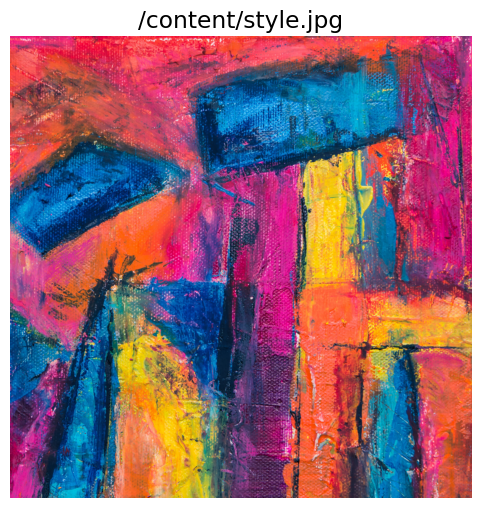

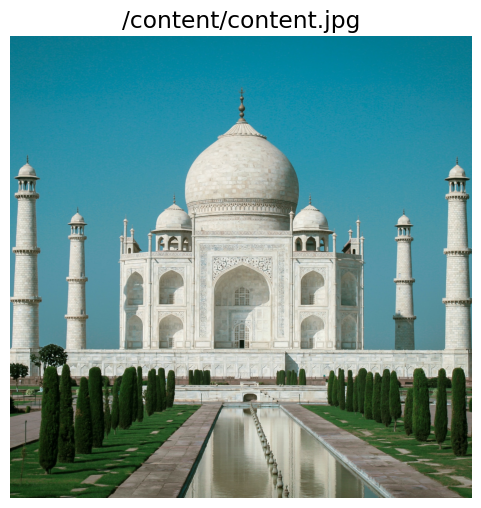

In [5]:
def image_to_tensor(image_filepath, image_dimension=128):
  img = Image.open(image_filepath).convert('RGB')

  plt.figure()
  plt.title(image_filepath)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  if max(img.size) <= image_dimension:
    img_size = max(img.size)
  else:
    img_size = image_dimension

  torch_transformation = torchvision.transforms.Compose([
      torchvision.transforms.Resize(img_size),
      torchvision.transforms.ToTensor()
  ])

  img = torch_transformation(img).unsqueeze(0) # batch

  return img.to(device)

style_image = image_to_tensor("/content/style.jpg")
content_image = image_to_tensor("/content/content.jpg")

# Gram matrix

In [6]:
a = content_image.size()
print(a)
content_image.view(3, 128*128).shape

torch.Size([1, 3, 128, 128])


torch.Size([3, 16384])

In [7]:
def gram_matrix(ip):
  num_batch, num_channels, height, width = ip.size()
  feats = ip.view(num_batch*num_channels, height*width)
  gram_mat = torch.mm(feats, feats.t())
  return gram_mat.div(num_batch*num_channels*height*width)

In [8]:
gram = gram_matrix(style_image)
print(gram)

tensor([[0.1359, 0.0633, 0.0615],
        [0.0633, 0.0467, 0.0449],
        [0.0615, 0.0449, 0.0624]], device='cuda:0')


## Pretrained Model, VGG19

In [9]:
weights = torchvision.models.VGG19_Weights.DEFAULT
vgg19_model = torchvision.models.vgg19(weights=weights).to(device)
print(vgg19_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [10]:
vgg19_model = vgg19_model.features
print(vgg19_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [11]:
for param in vgg19_model.parameters():
  param.requires_grad = False

In [12]:
vgg19_model[4]._get_name()

'MaxPool2d'

In [13]:
conv_indices = []

for i in range(len(vgg19_model)):
  if vgg19_model[i]._get_name() == 'MaxPool2d':
    vgg19_model[i] = nn.AvgPool2d(kernel_size=vgg19_model[i].kernel_size,
                                  stride=vgg19_model[i].stride,
                                  padding = vgg19_model[i].padding)
  if vgg19_model[i]._get_name() == 'Conv2d':
    conv_indices.append(i)

conv_indices = dict(enumerate(conv_indices, start=1))
print("conv_indices = ", conv_indices)
print(vgg19_model)

conv_indices =  {1: 0, 2: 2, 3: 5, 4: 7, 5: 10, 6: 12, 7: 14, 8: 16, 9: 19, 10: 21, 11: 23, 12: 25, 13: 28, 14: 30, 15: 32, 16: 34}
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3)

## Select relevant layer

In [14]:
layers = {1: 's', 2: 's', 3: 's', 4: 'sc', 5: 's'}

In [15]:
vgg_layers = nn.ModuleList(vgg19_model)
display(conv_indices)

{1: 0,
 2: 2,
 3: 5,
 4: 7,
 5: 10,
 6: 12,
 7: 14,
 8: 16,
 9: 19,
 10: 21,
 11: 23,
 12: 25,
 13: 28,
 14: 30,
 15: 32,
 16: 34}

In [16]:
last_layer_idx = conv_indices[max(layers.keys())]
print(last_layer_idx)

vgg_layers_trimmed = vgg_layers[:last_layer_idx + 1]
print(vgg_layers_trimmed)

10
ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [17]:
neural_style_transfer_model = nn.Sequential(*vgg_layers_trimmed)
print(neural_style_transfer_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


## Input image 생성

In [96]:
content_image.data.size()

torch.Size([1, 3, 128, 128])

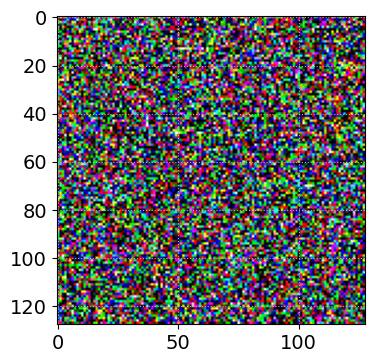

In [97]:
ip_image = torch.randn(content_image.shape).to(device)

plt.figure(figsize=(4, 4))
plt.imshow(ip_image.squeeze(0).cpu().numpy().transpose(1, 2, 0).clip(0, 1))
plt.show()

epoch number 0
style loss = 16317.3955078125, content loss = 23.526473999023438


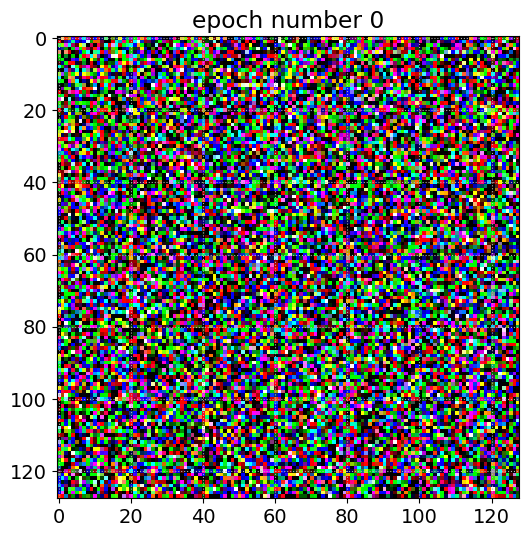

epoch number 1000
style loss = 1.628075361251831, content loss = 3.4320526123046875


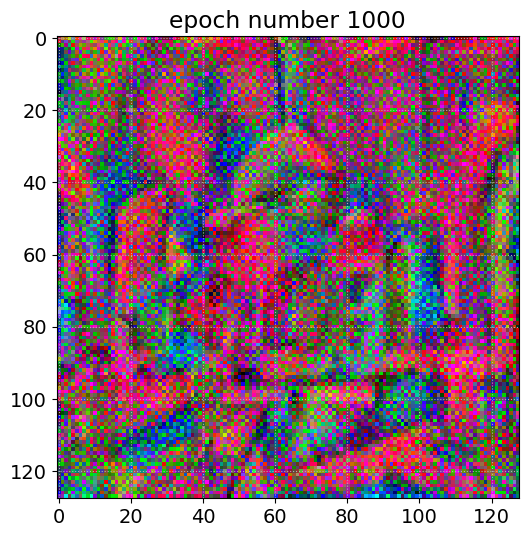

epoch number 2000
style loss = 0.6230678558349609, content loss = 2.4917025566101074


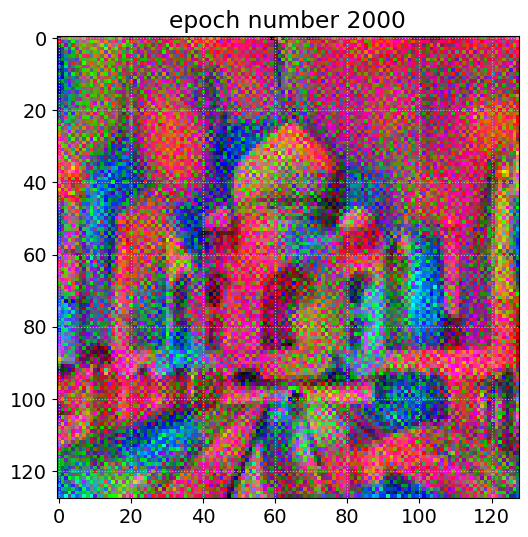

epoch number 3000
style loss = 0.41836050152778625, content loss = 2.2364354133605957


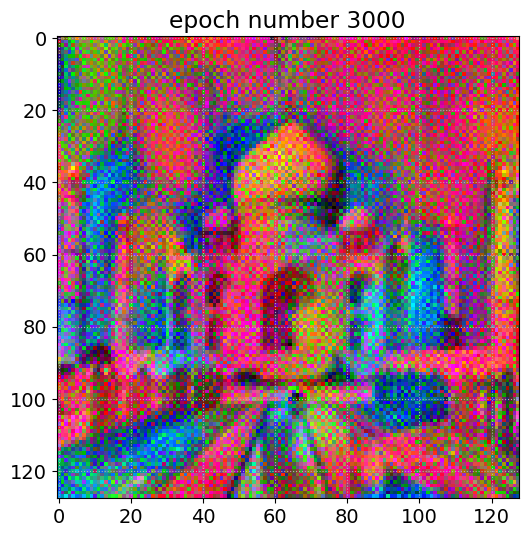

epoch number 4000
style loss = 0.3515145182609558, content loss = 2.1203629970550537


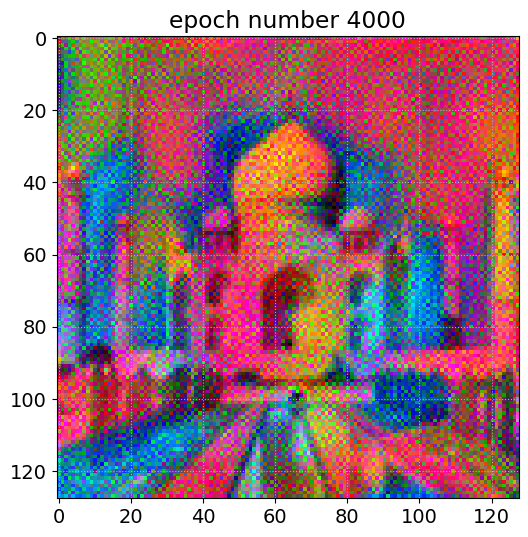

epoch number 5000
style loss = 0.3275096118450165, content loss = 2.052868366241455


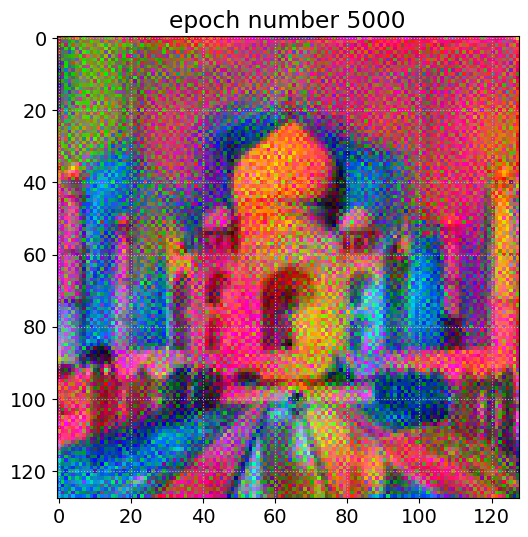

In [98]:
num_epochs = 5001
wt_style = 1000000
wt_content = 1
style_losses = []
content_losses = []
lr = 0.01
optimizer = optim.Adam([ip_image.requires_grad_()], lr=lr)

for curr_epoch in range(num_epochs):
  ip_image.data.clamp(0, 1)
  epoch_style_loss = 0
  epoch_content_loss = 0

  for k in layers.keys(): # layers = {1: 's', 2: 's', 3: 's', 4: 'sc', 5: 's'}
    if 'c' in layers[k]:
      target = neural_style_transfer_model[:conv_indices[k]+1](content_image).detach()
      ip = neural_style_transfer_model[:conv_indices[k]+1](ip_image)
      epoch_content_loss += torch.nn.functional.mse_loss(ip, target)
    if 's' in layers[k]:
      target = gram_matrix(neural_style_transfer_model[:conv_indices[k]+1](style_image)).detach()
      ip = gram_matrix(neural_style_transfer_model[:conv_indices[k]+1](ip_image))
      epoch_style_loss += torch.nn.functional.mse_loss(ip, target)

  epoch_style_loss *= wt_style
  epoch_content_loss *= wt_content
  total_loss = epoch_style_loss + epoch_content_loss

  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  style_losses.append(epoch_style_loss.item())
  content_losses.append(epoch_content_loss.item())

  if curr_epoch % 1000 == 0:
        print(f"epoch number {curr_epoch}")
        print(f"style loss = {epoch_style_loss}, content loss = {epoch_content_loss}")
        plt.figure()
        plt.title(f"epoch number {curr_epoch}")
        plt.imshow(ip_image.data.clamp_(0, 1).squeeze(0).cpu().detach().numpy().transpose(1,2,0))
        plt.show()
        # style_losses += [epoch_style_loss]
        # content_losses += [epoch_content_loss]
        # style_losses.append(epoch_style_loss.item())
        # content_losses.append(epoch_content_loss.item())

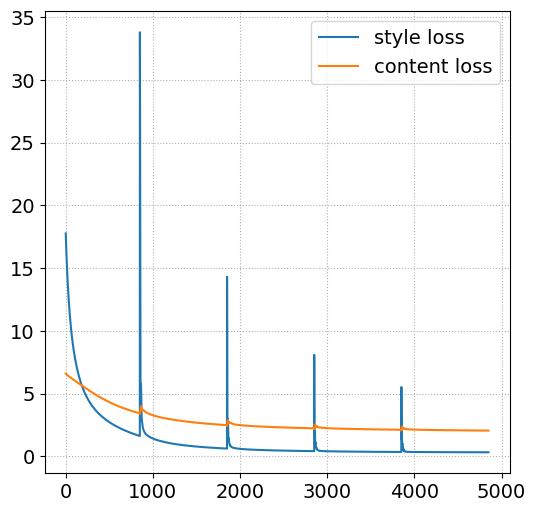

In [104]:
plt.plot(style_losses[150:], label='style loss')
plt.plot(content_losses[150:], label='content loss')
plt.legend()
plt.show()

# LSTM을 이용한 네이버 영화 리뷰 분류

In [22]:
import pandas as pd
from urllib import request

In [23]:
input_dim = 5
hidden_size = 3

inputs = torch.rand(1, 3, 5)
print(inputs)
print(inputs.shape)

tensor([[[0.9218, 0.9863, 0.8185, 0.9132, 0.3099],
         [0.8257, 0.6303, 0.4873, 0.0823, 0.8689],
         [0.8526, 0.1701, 0.0461, 0.2754, 0.5263]]])
torch.Size([1, 3, 5])


In [24]:
input_dim = 5
hidden_size = 3

lstm = nn.LSTM(input_dim, hidden_size, batch_first=True)
print(list(lstm.parameters()))

[Parameter containing:
tensor([[-0.4170,  0.0243, -0.1553,  0.1976,  0.1936],
        [ 0.2355, -0.4963,  0.1697, -0.3864,  0.3452],
        [-0.2161, -0.3367, -0.1887,  0.3421,  0.3451],
        [ 0.3163,  0.3016, -0.0051,  0.1465, -0.4888],
        [-0.1226,  0.2832,  0.1806, -0.1315,  0.0972],
        [-0.3545,  0.2630, -0.5154, -0.0490, -0.5604],
        [ 0.3942, -0.2829, -0.5751, -0.3030, -0.1211],
        [ 0.3717, -0.3441,  0.3564, -0.2223,  0.5543],
        [ 0.5175, -0.0228,  0.4640,  0.3008, -0.4871],
        [-0.3996, -0.0859, -0.3451,  0.4406,  0.1518],
        [-0.4781, -0.3778,  0.3978,  0.0074, -0.0448],
        [ 0.0489, -0.0654, -0.5678, -0.3714, -0.1040]], requires_grad=True), Parameter containing:
tensor([[ 0.3339,  0.1997, -0.0359],
        [ 0.3447, -0.5058,  0.5063],
        [-0.0226,  0.3331, -0.1088],
        [-0.0846, -0.4212, -0.2753],
        [ 0.0325, -0.5402,  0.2980],
        [ 0.0841,  0.4942,  0.2029],
        [ 0.3777,  0.0713,  0.2910],
        [ 0.48

In [25]:
request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt",
                    filename="ratings_train.txt")
request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt",
                    filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7937e458e2d0>)

In [38]:
train_data = pd.read_table('ratings_train.txt', sep='\t', nrows=10000)
test_data = pd.read_table('ratings_test.txt', sep='\t', nrows=10000)
print(train_data.shape)
print(test_data.shape)
train_data.head()

(10000, 3)
(10000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [42]:
## 데이터 전처리
# train_data.shape # (10000, 3)

train_data.dropna(inplace=True, how='any')
# print(train_data.shape)
train_data.drop_duplicates(subset=['document'], inplace=True)
print(train_data.shape)
train_data.head()

(9918, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [43]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", " ", regex=True)
train_data.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
##
train_data['document'] = train_data['document'].str.strip()
train_data['document'] = train_data['document'].replace('', np.nan)
train_data.dropna(inplace=True)

In [46]:
print(train_data.isnull().sum())
print(train_data.shape)

id          0
document    0
label       0
dtype: int64
(9858, 3)


## Tokenization (토큰)

In [47]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 36.1 MB/s eta 0:00:00


In [48]:
from konlpy.tag import Okt
from tqdm import tqdm

In [50]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

okt = Okt()
okt.morphs("아 더빙 진짜 짜증나네요 목소리") # 형태소 분리

['아', '더빙', '진짜', '짜증나네요', '목소리']

In [51]:
X_data = []
for sentence in tqdm(train_data['document']):
  tokenized_sentence = okt.morphs(sentence, stem=True)
  stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
  X_data.append(stopwords_removed_sentence)

100%|██████████| 9858/9858 [00:17<00:00, 560.09it/s]


## Target label

In [66]:
train_data.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [68]:
y_data = train_data['label']
print(len(X_data))
print(len(y_data))

print(X_data[:5])
print(y_data[:5])

9858
9858
[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천'], ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'], ['사이', '몬페', '그', '익살스럽다', '연기', '돋보이다', '영화', '스파이더맨', '에서', '늙다', '보이다', '하다', '커스틴', '던스트', '너무나도', '이쁘다', '보이다']]
0    0
1    1
2    0
3    0
4    1
Name: label, dtype: int64


## Training set, Test set

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.2,
                                                      random_state=0, stratify=y_data)

print(len(X_train))
print(len(X_valid))
print(len(y_train))
print(len(y_valid))

7886
1972
7886
1972
